<a href="https://colab.research.google.com/github/pantelisziazo/various_projects/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


## Overview

In this script I apply **Sentiment Analysis** over a specific (*non-public available*) dataset. 

The main purpose of this project is to make a classifer that **reads a tweet** and finds the **sentiment** of the it (e.g. if the tweet expresses something negative or has neutral sentiment).


## More information



*   My objective is to write a script that is **affordable to everyone** : runs quite fast, is easy to read and understandable. That means that I will make use of [Colab](https://colab.research.google.com/) platform, do not make extensive analysis of the data (but provide information about future improvements) and write as clear code as possible. 
*   I will try to keep the *workload* needed for this task to less than the workload of a working day.
*   The dataset includes sensitive data at some cases. So the appearance of it is going to be *blurred*.
*   For any question, please contact me through email at **larryziazo@gmail.com** .


# Classification

## Build the appropriate environment and take a first look at the data. 

In [1]:
# import all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from scipy import sparse


In [2]:
# read the .json file with the data
data = pd.read_json('/content/palo_assignment.json', lines =True)

In [3]:
# the command below is to make blurry the appearance of the pandas Dataframes
def blurry(s):
    return 'color: transparent; text-shadow: 0 0 5px rgba(0,0,0,0.5)'

data.head().style.applymap(blurry)

,id,channel,text,createdate,impact,query_name,sentiment
0,1402218796425924611,twitter,RT @re_aiiii: H eurobank έβγαλε διαφήμιση ότι ανησυχεί για το δημογραφικό. Κάντε παιδιά ρε μλκες να τους χρωστάνε μια ζωή τι σας ζητάνε ...,2021-06-08 10:59:47.000,0.200000,Eurobank,negative
1,1441689475105624067,twitter,"RT @GTrapeziotis: Κανονικά ο Βαξεβάνης θα πρέπει να κάνει δωρεάν συνδρομή σε Μαξίμου-Πειραιώς, Documento έκδοση πλούσια-«σακούλα» με ηρεμηστικά, ντεπόν, κάτι… Ανάλγητος! #ΔΕΗ #κυβερνηση_Μητσοτακη #ποθεν_εσχες (για να μη ξεχνιόμαστε)",2021-09-25 09:02:10.000,0.100000,Piraeus Bank,neutral
2,1415971011229634565,twitter,ΔΕΛΤΙΟ ΤΥΠΟΥ Συνάντηση μελών της ΚΟ του ΜέΡΑ25 με τον ΣΕΥΤΠΕ: Το ΜέΡΑ25 στηρίζει τον αγώνα των εργαζομένων στην τράπεζα Πειραιώς Την Πέμπτη 15 Ιουλίου 2021 πραγματοποιήθηκε διαδικτυακή συνάντηση μελών της ΚΟ του ΜέΡΑ25 με αντιπροσωπεία του Συλλόγου https://t.co/7plbtWlcRD https://t.co/jy8QUoX5ei,2021-07-16 09:46:11.000,0.070000,Piraeus Bank,negative
3,1435188973878579202,twitter,"Στις τράπεζες, οριακή άνοδο καταγράφουν Πειραιώς +0,10% και Εθνική +0,05% ενώ ήπια υποχωρουν Alpha Bank +0,45% και Eurobank -0,40%.",2021-09-07 10:31:30.000,0.300000,Alpha Bank,neutral
4,1412508851467960320,twitter,"RT @spigaro: Πρόεδρος στην Εθνική Τράπεζα ο Γκίκας Χαρδούβελης ο οποίος ως υπουργός ""έσπαγε"" τα εμβάσματα σε δεκαχίλιαρα για να βγάλει τα λεφτά του στο εξωτερικό και να ξεγελάει τα ελεγκτικά όργανα. Η αριστεία και η τιμιότητα επιβραβεύονται γνωστά αυτά 😜",2021-07-06 20:28:47.000,0.130000,Ethniki Trapeza,negative


The data is : 

*   **id** : the index of the tweet. It does not provide a special information for the classification process that is why this column will be left out. 
*   **channel** : the source of the text phrase. All the texts are tweets (come from Twitter) so this column does not hold special information (will be left out).
*   **text** : the text phrase of a tweet. The main "x-value" of our classification problem. 
*   **createdate** : datetime variable at the format "Year-Month-Day Hour-Minutes-Seconds" .
*   **impact** : a numeric variable that takes values from 0 to 1 .
*   **query_name** : the bank name that each tweet refers to. 
*   **sentiment** : the sentiment of the tweet, the "y-value" of the classification problem, the variable that we want to predict.



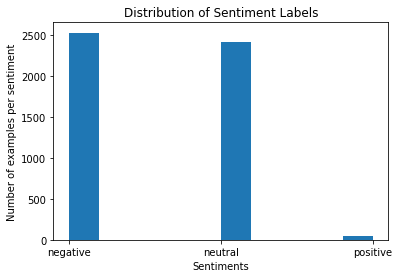

In [4]:
# histogram of the possible sentiments (the y-value)

plt.figure(figsize=(6,4))
plt.hist(data['sentiment'])
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiments')
plt.ylabel('Number of examples per sentiment')
plt.show()

In [5]:
# get the exact number of each category
Counter(data['sentiment'])

Counter({'negative': 2533, 'neutral': 2425, 'positive': 42})

As we see the sentiment variable of the dataset is quite unbalnced. Having only 42 examples of the category 'Positive' when the other 2 have over 2000 . That is a problem that needs special treatment.


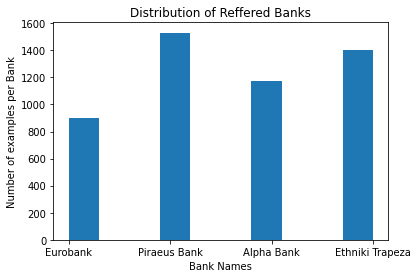

In [6]:
# histogram of the possible Banks the tweets are reffered to

plt.figure(figsize=(6,4))
plt.hist(data['query_name'])
plt.title('Distribution of Reffered Banks')
plt.xlabel('Bank Names')
plt.ylabel('Number of examples per Bank')
plt.show()

## Get an insight of the dataset

The dataset seems quite interesting and easy to extract information.
Here I will try to answer some questions, like :

*   Which was the month with the most negative sentiment ? 
*   Which was the bank with the most negative tweets at the above month ? 
* Any other correlation between the data ? 



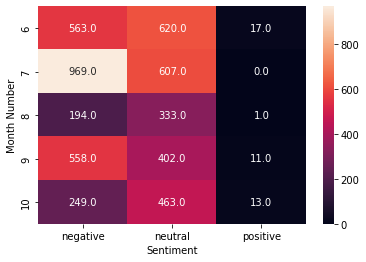

In [7]:
# read only the day , not the time of the 'createdate' column
dates = [date.split(" ")[0] for date in data['createdate']]
# parse the 'Month' of each tweet
months = [datetime.datetime.strptime(month, "%Y-%m-%d").month for month in dates]
# make a heatmap
sns.heatmap(pd.crosstab(pd.Series(months, name='Month Number'),
                        pd.Series(list(data['sentiment']), name='Sentiment')), annot=True,fmt=".1f")

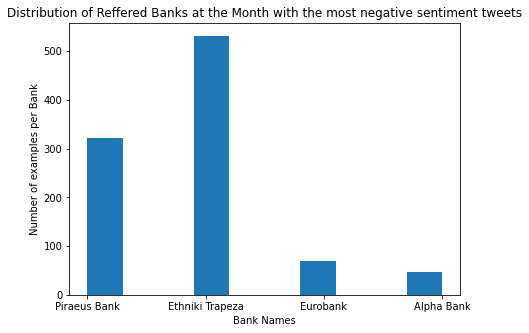

In [8]:
# append the Months to the dataframe
data['Month'] = months
# get the data that refer to month with the most negative sentiment (7)
most_negative_month_data = data[data['Month'] == 7]
bank_most_negative_month_data = most_negative_month_data[most_negative_month_data['sentiment'] == 'negative']

plt.figure(figsize=(7,5))
plt.hist(bank_most_negative_month_data['query_name'])
plt.title('Distribution of Reffered Banks at the Month with the most negative sentiment tweets')
plt.xlabel('Bank Names')
plt.ylabel('Number of examples per Bank')
plt.show()
plt.show()

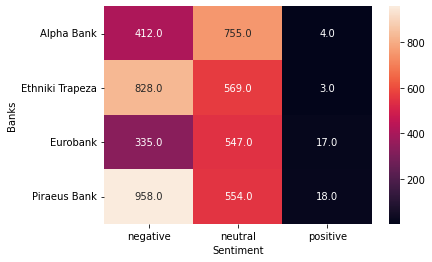

In [9]:
# additional correlation betweenthe data
# correlation between the banks and the sentiment
sns.heatmap(pd.crosstab(pd.Series(list(data['query_name']), name='Banks'),
                        pd.Series(list(data['sentiment']), name='Sentiment')), annot=True,fmt=".1f")

In [10]:
# correlation of the banks with the impact variable
data['query_name'].astype('category').cat.codes.corr(data['impact'])
# almost 0 -> possibly does not hold a great insight if we wanted to predict the bank names

-0.048679790244432836

0.32434233334213525


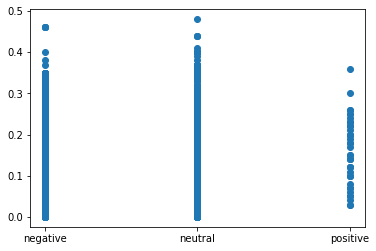

In [11]:
# correlation and scatter plot of the sentiment with the impact varible
print(data['sentiment'].astype('category').cat.codes.corr(data['impact']))
# different from zero -> the classification results may be better if we include this variable too

plt.scatter(x = data['sentiment'], y = data['impact'])
plt.show()

## Final pre-processing of the data

In [12]:
# convert the string variables to numerical in order to be inserted to the classifier
data['query_number'] = data['query_name'].astype('category')
data['query_number'] = data['query_number'].cat.codes

Since the dataset is unbalnced and I want to find a quick solution, I am going to **left out** the examples of the **'Positive' sentiment** category in order to **simplify the problem**. 

Someone else could apply oversampling over the 'Positive' category at the train subset only in order to increase the examples of the 'Positive' category. 

In the case that the dataset had more examples but with the same unbalance as here, someone could apply indersampling over the 2 other categories ('Negative' and 'Neutral') over the training subset only. 

In [13]:
# drop the unnecessary data
# if you still prefer to hold the 'positive' category just omit the command-line below 
# (and also re-define the calculation of f1 score )
data.drop(data[data['sentiment'] == 'positive'].index, inplace=True)

# these 2 columns do not hold information
data = data.drop(labels=['id','channel'], axis=1)

In [14]:
y_data = data['sentiment']
x_data = data.drop(['sentiment'], axis=1)

# split the dataset to train, development and test subsets
x_nontest, x_test, y_nontest, y_test = train_test_split(x_data, y_data, random_state= 3, test_size=0.15)
x_train, x_dev, y_train, y_dev = train_test_split(x_nontest, y_nontest, random_state= 3, test_size=0.2)


In [15]:
# define a function that concatenates the tfidf matrix with another column of the dataset

def matrix_plus_variables(matrix,variable_data):
  matrix_array = matrix.toarray()
  output = []
  for i in range(len(variable_data)):
    output.append(np.append(matrix_array[i],variable_data[i]))
  return sparse.csr_matrix(output)

## Hyper-parameter tuning

In [16]:
# define the hyperparameter of the problem 
ngram_range = [1,2]
max_features = [100,500]
max_tf = [0.75,0.9]
min_tf = [5,10]
regularization_strength = [1, 0.1, 0.01, 0.001]

In [17]:
accuracies, f_scores = [], []
best_ac , best_f1 = 0,0

for a in ngram_range:
  for b in max_features:
    for c in max_tf:
      for d in min_tf:
        # turn text to tfidf embeddings
        vectorizer = TfidfVectorizer(ngram_range=(1, a), max_features = b, max_df= c, min_df= d)
        xtrain_tfidf = vectorizer.fit_transform(x_train['text'])
        xdev_tfidf = vectorizer.transform(x_dev['text'])
        # concatenate the 'bank name' variable to the future input of the classifier 
        x_train_data = matrix_plus_variables(xtrain_tfidf,list(x_train['query_number']))        
        x_dev_data = matrix_plus_variables(xdev_tfidf,list(x_dev['query_number']))
        # concatenate the 'impact' variable to the future input of the classifier
        x_train_data = matrix_plus_variables(x_train_data,list(x_train['impact']))        
        x_dev_data = matrix_plus_variables(x_dev_data,list(x_dev['impact']))

        # define the classifier
        for e in regularization_strength:
          logistic = LogisticRegression(C=e)
          logistic.fit(x_train_data, y_train)
          predictions = logistic.predict(x_dev_data)

          # calculate the scores
          ac = accuracy_score(y_dev, predictions)
          accuracies.append(ac)
          f1 = f1_score(y_dev,predictions, pos_label='negative')
          f_scores.append(f1)

          # hold the best scoring parameters
          if ac > best_ac:
            best_ac = ac
            ac_ngram, ac_maxfeatures, ac_maxtf, ac_mintf, ac_regularization = a,b,c,d,e
          if f1 > best_f1:
            best_f1 = f1
            f1_ngram, f1_maxfeatures, f1_maxtf, f1_mintf, f1_regularization = a,b,c,d,e            

In [18]:
# print the highest scoring parameters
for i in [ac_ngram, ac_maxfeatures, ac_maxtf, ac_mintf, ac_regularization]:
  print(i)
print("Best accuracy at hyperparameter tuning = ", best_ac)
print()
print()

for i in [f1_ngram, f1_maxfeatures, f1_maxtf, f1_mintf, f1_regularization]:
  print(i)
print("Best F1 score at hyperparameter tuning = ", best_f1)

1
500
0.75
5
1
Best accuracy at hyperparameter tuning =  0.8766310794780545


1
500
0.75
5
1
Best F1 score at hyperparameter tuning =  0.8902953586497891


## Final Model

In [19]:
# highest scoring accuracy model
# follow the same process as in the hyperparameter tuning

ac_vectorizer = TfidfVectorizer(ngram_range=(1, ac_ngram), max_features = ac_maxfeatures,
                                max_df= ac_maxtf, min_df= ac_mintf)
xnontest_tfidf = ac_vectorizer.fit_transform(x_nontest['text'])
xtest_tfidf = ac_vectorizer.transform(x_test['text'])
x_nontest_data = matrix_plus_variables(xnontest_tfidf,list(x_nontest['query_number']))        
x_test_data = matrix_plus_variables(xtest_tfidf,list(x_test['query_number']))
x_nontest_data = matrix_plus_variables(x_nontest_data,list(x_nontest['impact']))        
x_test_data = matrix_plus_variables(x_test_data,list(x_test['impact']))

ac_logistic = LogisticRegression(C = ac_regularization)
ac_logistic.fit(x_nontest_data, y_nontest)
ac_predictions = ac_logistic.predict(x_test_data)

final_ac = accuracy_score(y_test, ac_predictions)
print("Final Accuracy = ", final_ac)
final_f1 = f1_score(y_test, ac_predictions, pos_label="negative")
print("Final F1 score = ", final_f1)

Final Accuracy =  0.8669354838709677
Final F1 score =  0.8656716417910447


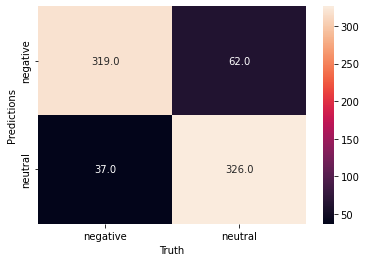

In [20]:
# a heatmap of the true - predicted values
sns.heatmap(pd.crosstab(pd.Series(ac_predictions, name='Predictions'),
                        pd.Series(list(y_test), name='Truth')), annot=True,fmt=".1f")

# Additional information regarding TF-IDF scores of the dataset

Try to find the top N n-grams (unigrams, bigrams, trigrams) according to tf-idf scores

In [21]:
data = pd.read_json('/content/palo_assignment.json', lines =True)

def get_top_ngrams(ngram_range = 1 , top_n = 20, text = data['text']):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=(ngram_range, ngram_range), min_df=10) # keep fewer features
  # get the ngrams to array matrix
  ngrams = tfidf_vectorizer.fit_transform(text).toarray()
  # get the name of the features
  feature_names = tfidf_vectorizer.get_feature_names()
  # make a dataframe with the tfidf score of each feature for each example
  tfidf_data = pd.DataFrame(ngrams, columns = feature_names)
  # sort the above dataframe
  sorted_tfidf_dataframe = pd.DataFrame(np.sort(tfidf_data.values, axis=0), index=tfidf_data.index, columns=tfidf_data.columns)
  # keep the highest scoring line
  top_tfidf_score = sorted_tfidf_dataframe.tail(1)
  # get the indices of the highest tfidf scoring words
  top_n_indices = np.argsort(top_tfidf_score.values)[0]
  top_n_values = []
  # locate the words and the tfidf score
  for i in top_n_indices[-top_n:]:
    top_n_values.append(top_tfidf_score.iloc[:,i])
  return top_n_values

In [22]:
# for 1-gram , top 20
answer1 = get_top_ngrams(ngram_range=1,top_n=20)
answer1.reverse()
for i in answer1:
  print(i.values, "\t", i.name)

[1.] 	 γιουρομπανκ
[0.9337178] 	 μπράβο
[0.90696468] 	 λογαριασμού
[0.89080486] 	 αε
[0.87115022] 	 συμβούλου
[0.866515] 	 ολοκληρώθηκε
[0.86578127] 	 καμια
[0.84679569] 	 στους
[0.8440475] 	 ειναι
[0.83693654] 	 ούτε
[0.83616512] 	 ρυθμό
[0.83326651] 	 εχω
[0.829316] 	 thepressproject
[0.82558478] 	 δανεια
[0.82289901] 	 stress
[0.82098118] 	 συστήματος
[0.8169416] 	 alpha_bank
[0.81619749] 	 μετοχή
[0.81201992] 	 piraeus_bank
[0.81145166] 	 ημέρα


In [23]:
# for 2-grams , top 10
answer2 = get_top_ngrams(ngram_range=2,top_n=10)
answer2.reverse()
for i in answer2:
  print(i.values, "\t", i.name)

[1.] 	 και στο
[1.] 	 αλλά να
[1.] 	 για το
[1.] 	 για τις
[1.] 	 για την
[1.] 	 της alpha
[1.] 	 για τα
[1.] 	 για να
[1.] 	 για εξωσωματική
[1.] 	 και το


In [24]:
# for 3-grams , top 10
answer3 = get_top_ngrams(ngram_range=3,top_n=10)
answer3.reverse()
for i in answer3:
  print(i.values, "\t", i.name)

[1.] 	 λογαριασμούς https co
[1.] 	 από την piraeus_bank
[1.] 	 από εθνική τράπεζα
[1.] 	 σύμφωνα με το
[1.] 	 αμκ https co
[1.] 	 τα λεφτά μου
[1.] 	 τα λεφτά της
[1.] 	 τα λεφτά του
[1.] 	 τα χρέη του
[1.] 	 την alpha bank


# Conclusion

## Summary

In order to complete the task above I worked 5 hours, wanting to keep the workload at the levels of a single working day.

The process I followed :

*   Take a look at the dataset and get a quick insight of it 
*   Decide the variables I will include to the classification process
*   Build (tune and train) a classifier



It is obvious that the results are promising and have margins for improvement.

## Future Work


The most promising ways to improve this classifier are:    

*   Insert the datetime variable to the problem. The hour that each tweet is posted may hold information about the sentiment.
*   Keep the 'positive' category and apply oversampling at the train set of the task.
*   Exclude stopwords of the text while applying the Tf-Idf vectorizer.
*   Make more extensive hyper-paramter tuning.
*   Try more complex classifiers, like a MLP. 


---

I hope you find this script understandable and funny to read. 

